In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import re
import string

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics  import accuracy_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\James\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
#Dataset from: https://www.kaggle.com/thoughtvector/customer-support-on-twitter
twcs = pd.read_csv('twcs.csv',encoding='utf-8')
print("Shape:" + str(twcs.shape))
twcs.head(5)

Shape:(2811774, 7)


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [3]:
#Create a conversation
first_inbound = twcs[pd.isnull(twcs.in_response_to_tweet_id) & twcs.inbound]

convo = pd.merge(first_inbound, twcs, left_on='tweet_id', 
                                  right_on='in_response_to_tweet_id').sample(frac=1)
print("After lines merged into conversation:")
print('convo shape: ', convo.shape)
display(convo.head(5))

After lines merged into conversation:
convo shape:  (875292, 14)


,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
533182,1892636,564318,True,Sun Oct 22 23:51:40 +0000 2017,@115911 service reliability really sucks 👎🏿👎🏿👎...,1892635,NaN,1892635,TMobileHelp,False,Sun Oct 22 23:54:00 +0000 2017,@564318 I definitely need my service to be top...,NaN,1892636.0
477886,1719241,243538,True,Sun Nov 26 05:01:40 +0000 2017,Hey @115850 if your couriers don't want to wor...,1719240,NaN,1719240,243538,True,Sun Nov 26 05:03:45 +0000 2017,@115850 Your couriers are repeatedly refusing ...,1719239,1719241.0
633314,2196559,642636,True,Thu Nov 09 23:08:02 +0000 2017,"""We live in a society where pizza gets to your...",2196558,NaN,2196558,AskPapaJohns,False,Thu Nov 09 23:13:25 +0000 2017,@642636 We're sorry your pizza arrived this wa...,NaN,2196559.0
704548,2427896,454971,True,Tue Nov 14 19:47:43 +0000 2017,@AskPlayStation Any help why the live chat can...,2427895,NaN,2427895,AskPlayStation,False,Tue Nov 14 19:50:11 +0000 2017,@454971 We have sent you a Direct Message via ...,NaN,2427896.0
116005,444818,220365,True,Tue Nov 21 19:15:21 +0000 2017,Always good to see phone networks fighting ove...,444817,NaN,444817,O2,False,Wed Nov 22 09:58:10 +0000 2017,@220365 We fight for the things we love Ed 😉 😘,NaN,444818.0


In [4]:
#Only care about the company name and the tweets
toDrop = ['author_id_x', 'tweet_id_x', 'inbound_x', 'created_at_x', 'created_at_y', 'response_tweet_id_x', 'in_response_to_tweet_id_x', 
          'tweet_id_y', 'inbound_y','response_tweet_id_y', 'in_response_to_tweet_id_y']
convo.drop(toDrop, axis=1, inplace=True)

print("After dropped columns:")
print('convo shape: ', convo.shape)
display(convo.head(5))

After dropped columns:
convo shape:  (875292, 3)


,text_x,author_id_y,text_y
533182,@115911 service reliability really sucks 👎🏿👎🏿👎...,TMobileHelp,@564318 I definitely need my service to be top...
477886,Hey @115850 if your couriers don't want to wor...,243538,@115850 Your couriers are repeatedly refusing ...
633314,"""We live in a society where pizza gets to your...",AskPapaJohns,@642636 We're sorry your pizza arrived this wa...
704548,@AskPlayStation Any help why the live chat can...,AskPlayStation,@454971 We have sent you a Direct Message via ...
116005,Always good to see phone networks fighting ove...,O2,@220365 We fight for the things we love Ed 😉 😘


In [5]:
#Drop conversations where a company is not involved
convo = convo[convo.author_id_y.str.isalpha()]
print("After dropping rows where a company is not involved:")
print('convo shape: ', convo.shape)
display(convo.head(5))

After dropping rows where a company is not involved:
convo shape:  (643763, 3)


,text_x,author_id_y,text_y
533182,@115911 service reliability really sucks 👎🏿👎🏿👎...,TMobileHelp,@564318 I definitely need my service to be top...
633314,"""We live in a society where pizza gets to your...",AskPapaJohns,@642636 We're sorry your pizza arrived this wa...
704548,@AskPlayStation Any help why the live chat can...,AskPlayStation,@454971 We have sent you a Direct Message via ...
664469,I’ve never seen my #ipad do this before @11585...,AppleSupport,@666681 Thanks for reaching out. We want to ma...
860657,@115817 why tell me that something is going to...,UPSHelp,@812945 I'm sorry to hear that you have not re...


In [6]:
#remove all @ and links
convo["text_x"] =  convo["text_x"].str.replace("(?:\@|https?\://)\S+", "", regex=True)
convo["text_y"] =  convo["text_y"].str.replace("(?:\@|https?\://)\S+", "", regex=True)
print("After mentions and links are removed:")
print('convo shape: ', convo.shape)
display(convo.head(5))

After mentions and links are removed:
convo shape:  (643763, 3)


,text_x,author_id_y,text_y
533182,service reliability really sucks 👎🏿👎🏿👎🏿👎🏿 get...,TMobileHelp,"I definitely need my service to be top notch,..."
633314,"""We live in a society where pizza gets to your...",AskPapaJohns,We're sorry your pizza arrived this way! Plea...
704548,Any help why the live chat can’t find my acco...,AskPlayStation,We have sent you a Direct Message via Twitter...
664469,I’ve never seen my #ipad do this before,AppleSupport,Thanks for reaching out. We want to make sure...
860657,why tell me that something is going to be del...,UPSHelp,I'm sorry to hear that you have not received ...


In [7]:
PUNCT_TO_REMOVE = string.punctuation + "’“”"
print("PUNCTUATION TO REMOVE:" + str(PUNCT_TO_REMOVE))

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

convo["text_x"] = convo["text_x"].apply(lambda text: remove_punctuation(text))
convo["text_y"] = convo["text_y"].apply(lambda text: remove_punctuation(text))

print("After punctuation removed:")
print('convo shape: ', convo.shape)
display(convo.head(5))

PUNCTUATION TO REMOVE:!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~’“”
After punctuation removed:
convo shape:  (643763, 3)


,text_x,author_id_y,text_y
533182,service reliability really sucks 👎🏿👎🏿👎🏿👎🏿 get...,TMobileHelp,I definitely need my service to be top notch ...
633314,We live in a society where pizza gets to your ...,AskPapaJohns,Were sorry your pizza arrived this way Please...
704548,Any help why the live chat cant find my account,AskPlayStation,We have sent you a Direct Message via Twitter...
664469,Ive never seen my ipad do this before,AppleSupport,Thanks for reaching out We want to make sure ...
860657,why tell me that something is going to be del...,UPSHelp,Im sorry to hear that you have not received y...


In [8]:
#make everything lowercase
convo["text_x"] = convo["text_x"].str.lower()
convo["text_y"] = convo["text_y"].str.lower()

print("After changed to lowercase:")
print('convo shape: ', convo.shape)
display(convo.head(5))

After changed to lowercase:
convo shape:  (643763, 3)


,text_x,author_id_y,text_y
533182,service reliability really sucks 👎🏿👎🏿👎🏿👎🏿 get...,TMobileHelp,i definitely need my service to be top notch ...
633314,we live in a society where pizza gets to your ...,AskPapaJohns,were sorry your pizza arrived this way please...
704548,any help why the live chat cant find my account,AskPlayStation,we have sent you a direct message via twitter...
664469,ive never seen my ipad do this before,AppleSupport,thanks for reaching out we want to make sure ...
860657,why tell me that something is going to be del...,UPSHelp,im sorry to hear that you have not received y...


In [9]:
#REMOVE STOP WORDS
STOPWORDS = set(stopwords.words('english'))
print("STOPWORDS:" + str(stopwords.words('english')))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

convo["text_x"] = convo["text_x"].apply(lambda text: remove_stopwords(text))
convo["text_y"] = convo["text_y"].apply(lambda text: remove_stopwords(text))

print("After stop words are removed:")
print('convo shape: ', convo.shape)
display(convo.head(5))

STOPWORDS:['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',

,text_x,author_id_y,text_y
533182,service reliability really sucks 👎🏿👎🏿👎🏿👎🏿 get ...,TMobileHelp,definitely need service top notch get youre fe...
633314,live society pizza gets house police call poli...,AskPapaJohns,sorry pizza arrived way please reach friends t...
704548,help live chat cant find account,AskPlayStation,sent direct message via twitter instructions
664469,ive never seen ipad,AppleSupport,thanks reaching want make sure ipad working ex...
860657,tell something going delivered 445 truck drive...,UPSHelp,im sorry hear received package expected allows...


In [10]:
#REMOVE COMMON WORDS that won't end up being helpful
from collections import Counter
cnt = Counter()
for text in convo["text_x"].values:
    for word in text.split():
        cnt[word] += 1
        
for text in convo["text_y"].values:
    for word in text.split():
        cnt[word] += 1
        
print("100 most commons words:" + str(cnt.most_common(100)))
FREQWORDS = set([w for (w, wc) in cnt.most_common(100)])
def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

convo["text_x"] = convo["text_x"].apply(lambda text: remove_freqwords(text))
convo["text_y"] = convo["text_y"].apply(lambda text: remove_freqwords(text))

print("After common words are removed:")
print('convo shape: ', convo.shape)
display(convo.head(5))

100 most commons words:[('us', 234059), ('please', 212376), ('dm', 186975), ('help', 146965), ('hi', 136040), ('sorry', 108003), ('get', 99170), ('thanks', 94750), ('im', 90440), ('like', 78995), ('look', 78480), ('know', 69207), ('well', 68854), ('hey', 67614), ('service', 67096), ('send', 64584), ('phone', 57436), ('number', 57429), ('account', 57134), ('order', 52917), ('let', 51466), ('email', 49961), ('time', 49132), ('hear', 49125), ('address', 48402), ('issue', 48129), ('need', 46534), ('see', 45860), ('would', 45583), ('amp', 45292), ('flight', 44623), ('want', 43711), ('details', 42593), ('check', 42315), ('back', 42243), ('happy', 41667), ('dont', 41664), ('cant', 41470), ('wed', 41091), ('take', 40943), ('still', 40699), ('one', 39675), ('store', 38155), ('youre', 38038), ('team', 38029), ('could', 37938), ('thank', 37069), ('update', 36218), ('assist', 36143), ('new', 35325), ('iphone', 35125), ('today', 33114), ('customer', 32690), ('hello', 32479), ('going', 32251), ('del

,text_x,author_id_y,text_y
533182,reliability sucks 👎🏿👎🏿👎🏿👎🏿 together,TMobileHelp,definitely top notch feeling hit area jpl
633314,live society pizza gets house police police tu...,AskPapaJohns,pizza arrived reach friends
704548,live chat find,AskPlayStation,sent direct twitter instructions
664469,never seen ipad,AppleSupport,reaching ipad expected tap open open also vers...
860657,tell something delivered 445 truck drive apart...,UPSHelp,received package expected allows review reach ...


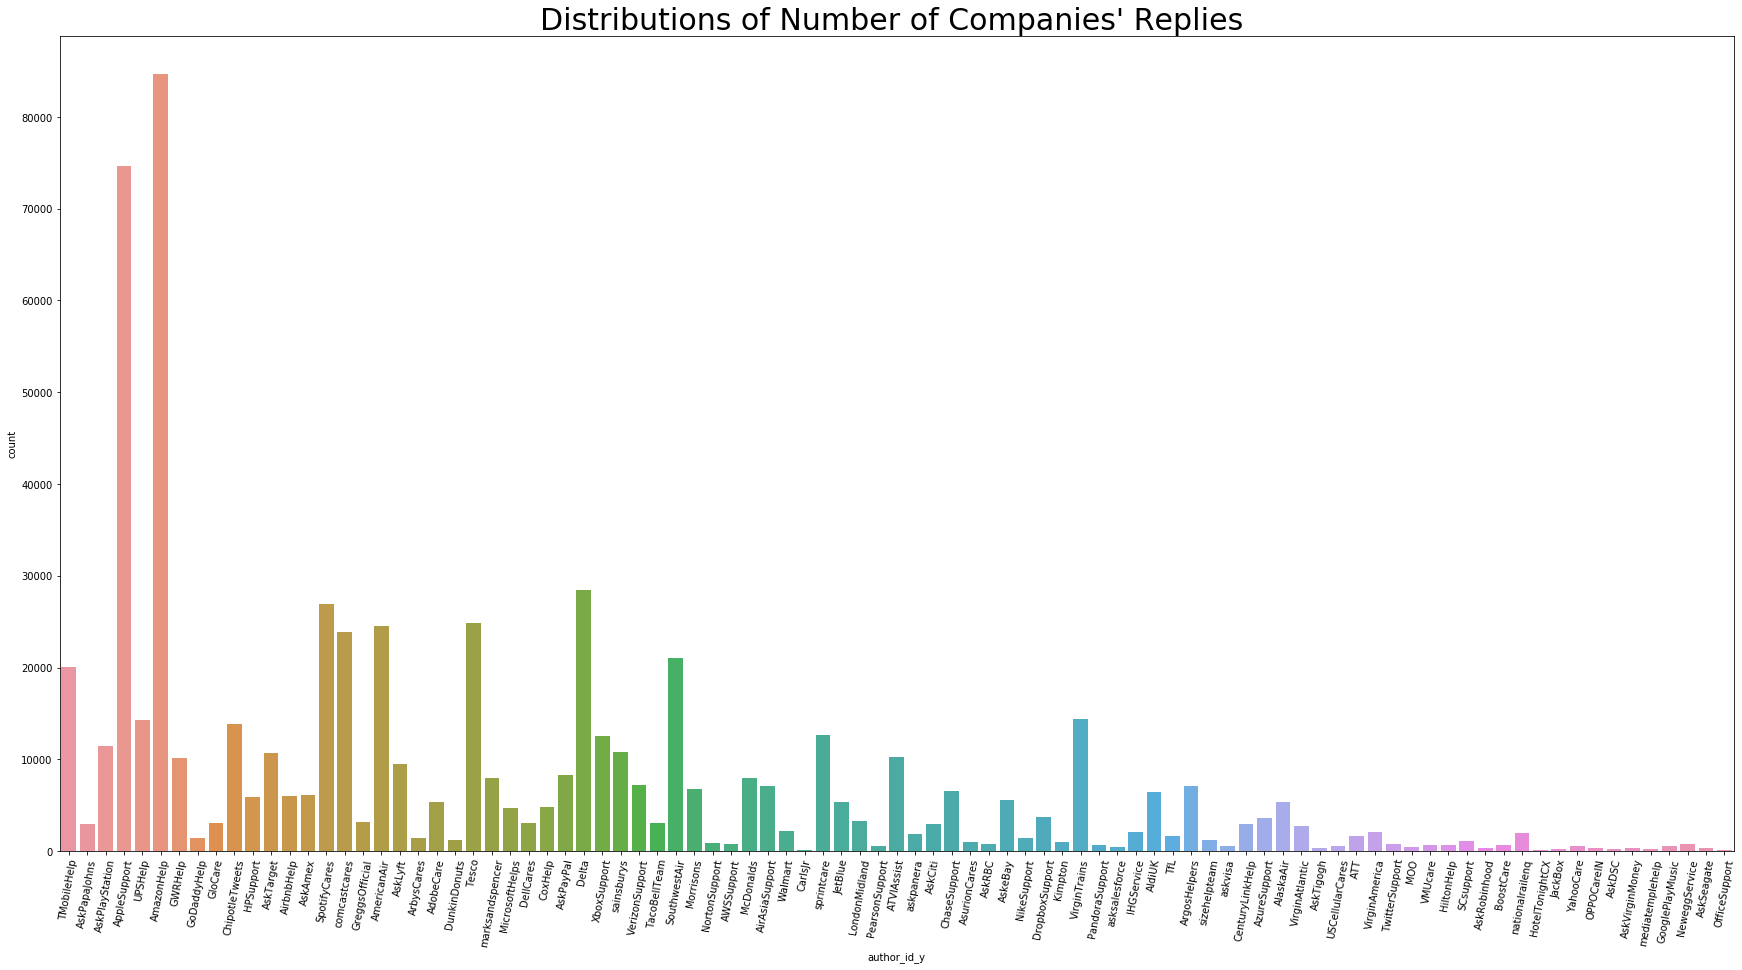

In [11]:
plt.figure(figsize=(30, 15))
sns.countplot(x='author_id_y', data=convo)
plt.xticks(rotation = 80)
plt.title("Distributions of Number of Companies' Replies ", fontsize = 30)
plt.show()

In [12]:
grouped_convos = convo.groupby(['author_id_y'])

concat_dict = {}
concat_df = pd.DataFrame(columns=['company', 'concat'])

for name in grouped_convos:
    concat_df = concat_df.append({'company':name[0], 'concat':name[1].text_x.str.cat(sep = " ")}, ignore_index=True)
    
concat_df.head(10)

,company,concat
0,ATT,nearly hours svc kicked says svc closed possib...
1,ATVIAssist,theres weird bug game connectivity errors join...
2,AWSSupport,best criteria determine whether workload redsh...
3,AdobeCare,afraid crashes adobe suite press ctrls multipl...
4,AirAsiaSupport,always said invalid person apps anytime adds s...
5,AirbnbHelp,booking nov 68 london host trying increase rat...
6,AlaskaAir,companion fare san every year next step mexico...
7,AldiUK,touch marketing pls tried morning buy kevin ka...
8,AmazonHelp,placed 261017 hasnt arrived past date needed c...
9,AmericanAir,offer smart stuff sfowhy else might discuss in...


In [13]:
#FIND TOP WORDS FROM EACH COMPANY
def find_topwords(text):
    tokens=word_tokenize(text)                                    
    frequency_dist = nltk.FreqDist(tokens)
    sortd = sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:10]
    return sortd

concat_df["top_words"] = concat_df["concat"].apply(lambda text: find_topwords(text))

display(concat_df.head(10))

,company,concat,top_words
0,ATT,nearly hours svc kicked says svc closed possib...,"[internet, pay, att, atampt, bill, month, wors..."
1,ATVIAssist,theres weird bug game connectivity errors join...,"[game, ww2, play, cod, error, servers, code, g..."
2,AWSSupport,best criteria determine whether workload redsh...,"[aws, lambda, s3, ec2, trying, find, instance,..."
3,AdobeCare,afraid crashes adobe suite press ctrls multipl...,"[cc, adobe, lightroom, premiere, photoshop, 20..."
4,AirAsiaSupport,always said invalid person apps anytime adds s...,"[booking, change, refund, ticket, airasia, bag..."
5,AirbnbHelp,booking nov 68 london host trying increase rat...,"[airbnb, host, booking, reservation, book, ref..."
6,AlaskaAir,companion fare san every year next step mexico...,"[alaska, iflyalaska, delayed, first, flights, ..."
7,AldiUK,touch marketing pls tried morning buy kevin ka...,"[aldi, christmas, kevin, bought, stores, year,..."
8,AmazonHelp,placed 261017 hasnt arrived past date needed c...,"[prime, delivered, de, ordered, package, days,..."
9,AmericanAir,offer smart stuff sfowhy else might discuss in...,"[gate, plane, delayed, aa, flights, fly, flyin..."


In [14]:
#Find top words for the whole thing
words = concat_df.concat.str.cat(sep=' ')
tokens = word_tokenize(words)

print("Total unique words:" + str(len(set(tokens))))

frequency_dist = nltk.FreqDist(tokens)
print(sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50])

Total unique words:256924
['i️', 'even', 'trying', 'days', 'guys', '3', 'last', 'never', 'since', 'wont', 'pay', 'every', 'doesnt', 'says', 'internet', 'didnt', 'ever', 'package', 'de', 'hours', 'delivered', 'home', 'online', 'bought', 'prime', 'u', 'first', 'find', 'train', '4', 'problem', 'someone', 'two', 'people', 'refund', 'money', 'yall', 'change', 'apple', 'week', 'yet', 'another', '1', 'worst', 'waiting', 'ordered', 'much', 'delayed', 'keep', 'game']


In [15]:
#SPLIT INTO TRAINING AND TESTING
X_train = convo.iloc[:600000, 0].values
y_train = convo.iloc[:600000, 1].values

X_test = convo.iloc[600001:, 0].values
y_test = convo.iloc[600001:, 1].values

In [16]:
#Do some transforming and vectorizing so can easily use Classifiers
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)
print(train_vectors.shape, test_vectors.shape)

(600000, 228948) (43762, 228948)


In [17]:
#NAIVE BAYES ~ 40%
clf = MultinomialNB().fit(train_vectors, y_train)
predicted = clf.predict(test_vectors)
print(accuracy_score(y_test,predicted))

0.41369224441296104


In [18]:
#KNN, k=1 ~ 31%
clf = KNeighborsClassifier(n_neighbors=1).fit(train_vectors, y_train)
predicted = clf.predict(test_vectors)
print(accuracy_score(y_test,predicted))

0.3383529089164115


In [19]:
clf = KNeighborsClassifier(n_neighbors=3).fit(train_vectors, y_train)
predicted = clf.predict(test_vectors)
print(accuracy_score(y_test,predicted))

0.2956217723138796


In [20]:
clf = KNeighborsClassifier(n_neighbors=5).fit(train_vectors, y_train)
predicted = clf.predict(test_vectors)
print(accuracy_score(y_test,predicted))

0.2724738357479091


In [21]:
clf = KNeighborsClassifier(n_neighbors=7).fit(train_vectors, y_train)
predicted = clf.predict(test_vectors)
print(accuracy_score(y_test,predicted))

0.2724052831223436


In [22]:
#DECISION TREE
clf = tree.DecisionTreeClassifier().fit(train_vectors, y_train)
predicted = clf.predict(test_vectors)
print(accuracy_score(y_test,predicted))

0.5315113568849686
